In [ ]:
!pip install scikit-learn

In [ ]:
!pip install umap-learn

In [ ]:
!pip install matplotlib

In [ ]:
!pip install pandas

In [16]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, Isomap, TSNE, trustworthiness
from sklearn.metrics import mean_squared_error
import umap.umap_ as umap
import matplotlib.pyplot as plt
from datasets.synthetic.swiss_roll import Swiss
from datasets.real_world.mnist import MNIST

In [17]:
def plot_reconstructions(original, reconstructed, title):
    """Plot original points and their reconstructions."""
    fig = plt.figure(figsize=(12, 6))
   
    ax1 = fig.add_subplot(121, projection='3d' if original.shape[1] == 3 else None)
    if original.shape[1] == 3:
        ax1.scatter(original[:, 0], original[:, 1], original[:, 2], 
                   c=original[:, 2], cmap=plt.cm.Spectral, s=10)
        ax1.set_title('Original Data')
    else:
        ax1.scatter(original[:, 0], original[:, 1], s=10)
        ax1.set_title('Original Data (first two dimensions)')

    ax2 = fig.add_subplot(122, projection='3d' if reconstructed.shape[1] == 3 else None)
    if reconstructed.shape[1] == 3:
        ax2.scatter(reconstructed[:, 0], reconstructed[:, 1], reconstructed[:, 2], 
                   c=reconstructed[:, 2], cmap=plt.cm.Spectral, s=10)
        ax2.set_title('PCA Reconstruction')
    else:
        ax2.scatter(reconstructed[:, 0], reconstructed[:, 1], s=10)
        ax2.set_title('PCA Reconstruction (first two dimensions)')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

Swiss Roll Results:


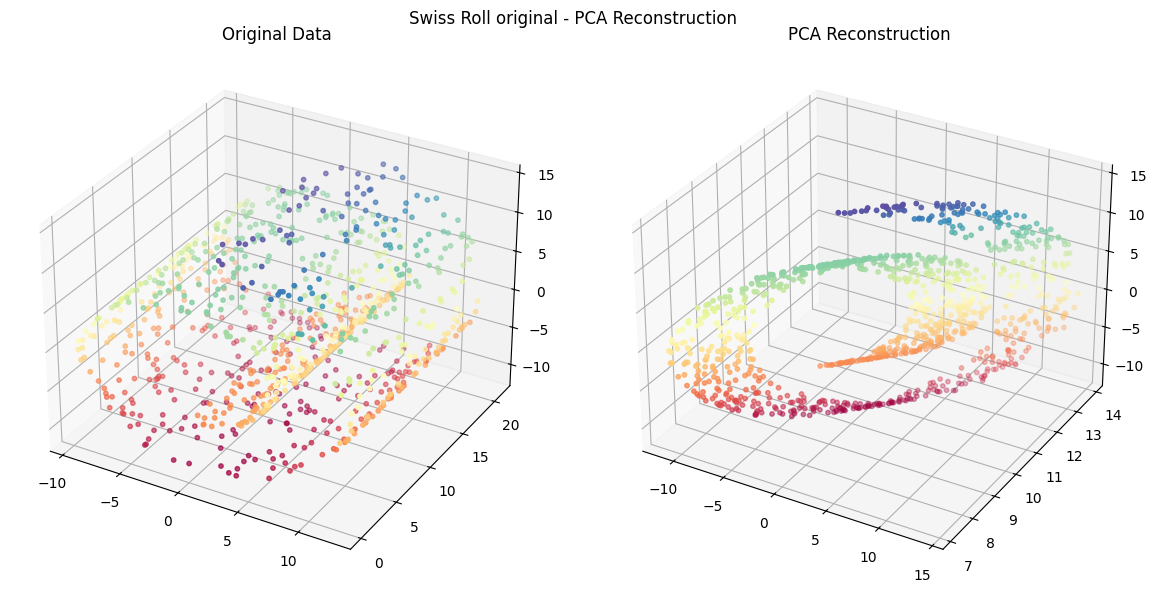

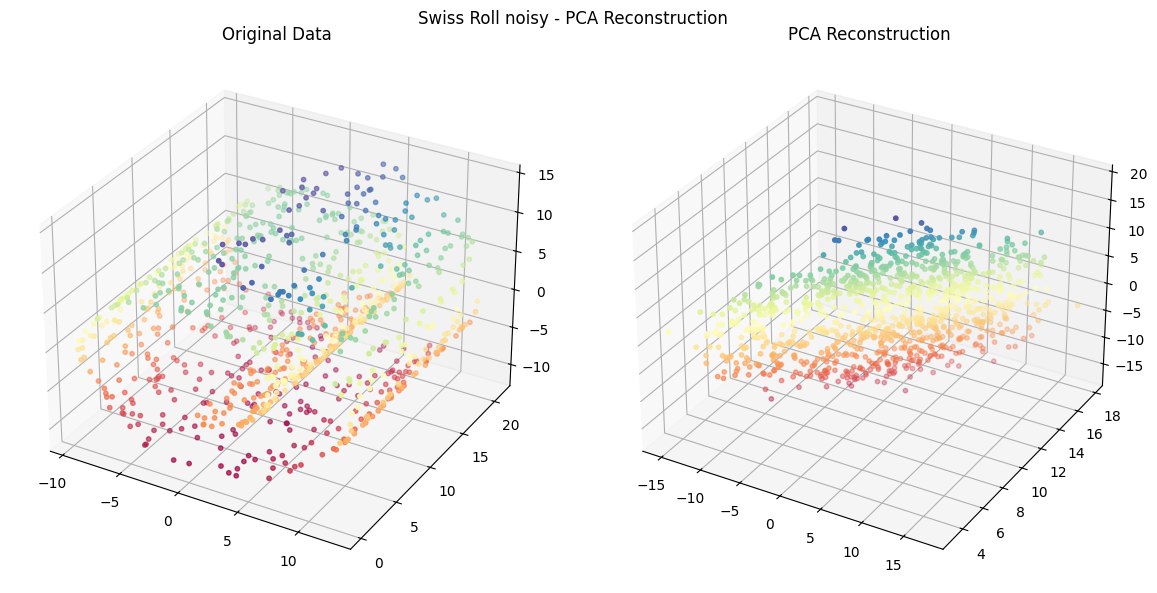

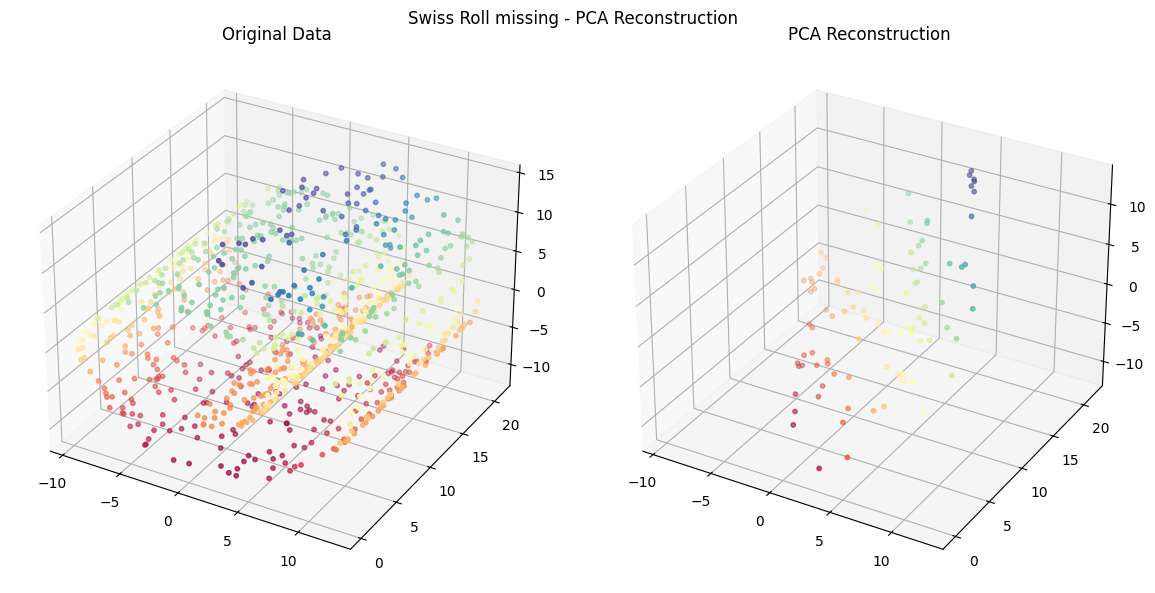


--- ORIGINAL ---
PCA: Trustworthiness = 0.974, Reconstruction Error = 12.390
MDS: Trustworthiness = 0.927
Isomap: Trustworthiness = 0.998
t-SNE: Trustworthiness = 0.999
UMAP: Trustworthiness = 0.998

--- NOISY ---
PCA: Trustworthiness = 0.877, Reconstruction Error = 15.000
MDS: Trustworthiness = 0.884
Isomap: Trustworthiness = 0.899
t-SNE: Trustworthiness = 0.995
UMAP: Trustworthiness = 0.993

--- MISSING ---
PCA: Trustworthiness = 0.890, Reconstruction Error = 12.205
MDS: Trustworthiness = 0.935
Isomap: Trustworthiness = 0.915
t-SNE: Trustworthiness = 0.988
UMAP: Trustworthiness = 0.982

MNIST Results:


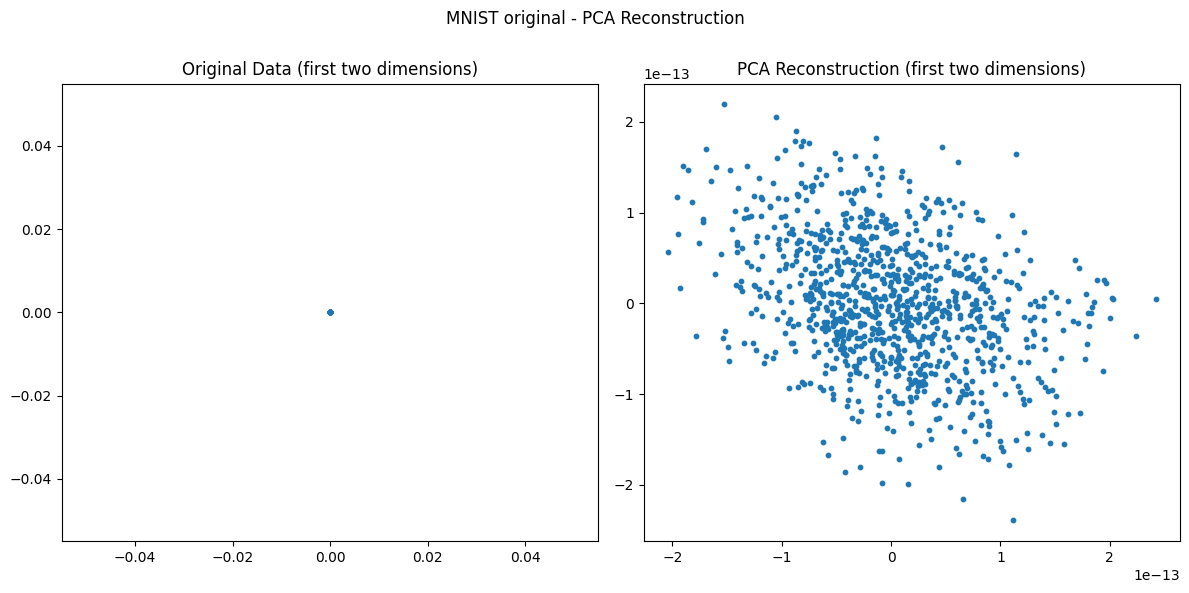

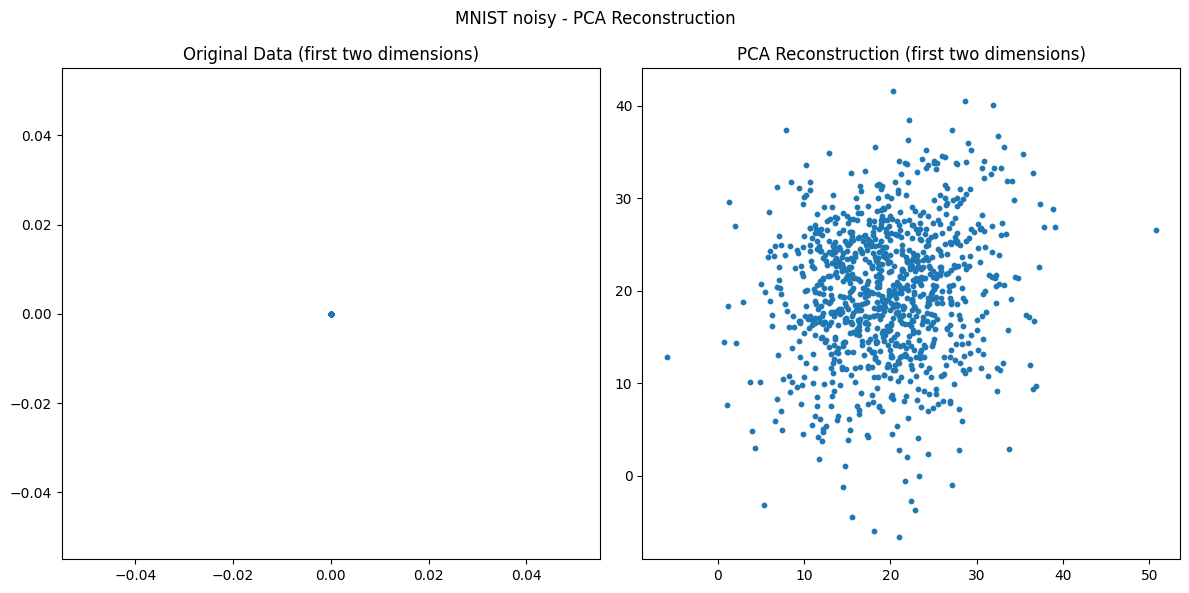

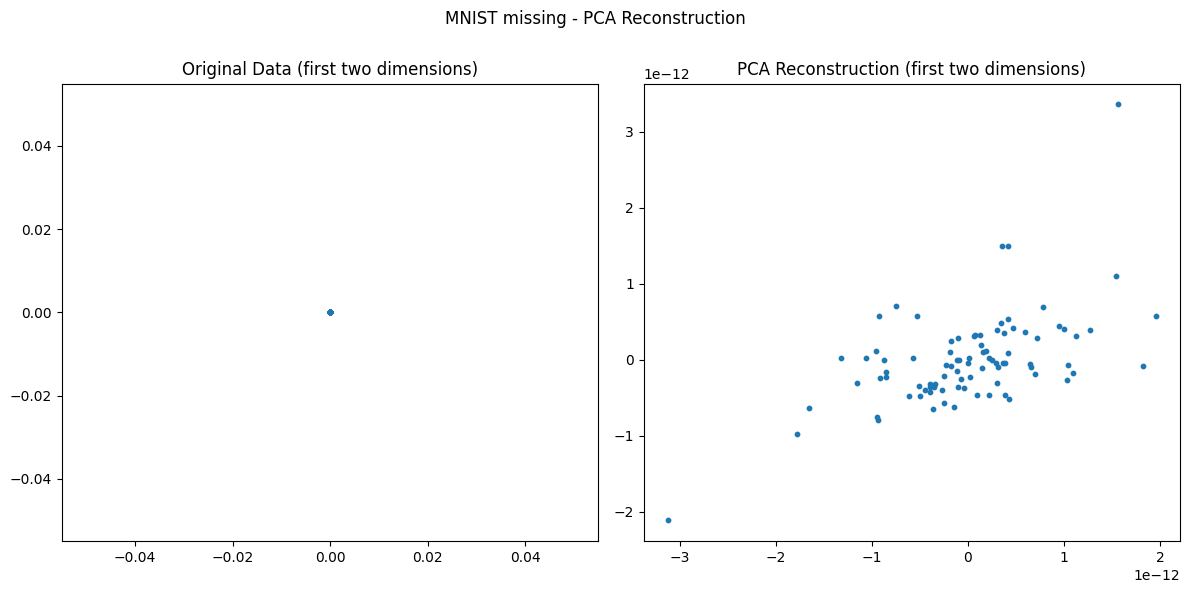

ValueError: There are significant negative eigenvalues (0.0124329 of the maximum positive). Either the matrix is not PSD, or there was an issue while computing the eigendecomposition of the matrix.

In [18]:
if __name__ == "__main__":
    # Swiss Roll datasets
    original_data = Swiss('original')
    original_data.create_swiss(n_samples=1000)
    noisy_data = Swiss('damage')
    noisy_data.create_swiss(n_samples=1000, noise=2.0)
    missing_data = Swiss('miss')
    missing_data.create_swiss(n_samples=1000, threshold=0.1)
    
    swiss_datasets = {
        'original': original_data,
        'noisy': noisy_data,
        'missing': missing_data
    }

    # MNIST datasets
    mnist_original = MNIST('original')
    mnist_original.create_mnist(n_samples=1000)
    mnist_noisy = MNIST('damage')
    mnist_noisy.create_mnist(n_samples=1000, noise=50.0)
    mnist_missing = MNIST('miss')
    mnist_missing.create_mnist(n_samples=1000, threshold=0.1)
    
    mnist_datasets = {
        'original': mnist_original,
        'noisy': mnist_noisy,
        'missing': mnist_missing
    }

    methods_swiss = {
        'PCA': PCA(n_components=2, random_state=42),
        'MDS': MDS(n_components=2, random_state=42, normalized_stress='auto'),
        'Isomap': Isomap(n_components=2),
        't-SNE': TSNE(n_components=2, random_state=42),
        'UMAP': umap.UMAP(random_state=42)
    }
    methods_mnist = {
        'PCA': PCA(n_components=55, random_state=42),
        'MDS': MDS(n_components=55, random_state=42, normalized_stress='auto'),
        'Isomap': Isomap(n_components=55),
        't-SNE': TSNE(n_components=2, random_state=42),
        'UMAP': umap.UMAP(random_state=42)
    }

    # Evaluate Swiss Roll
    print("Swiss Roll Results:")
    swiss_results = {}
    for data_name, data in swiss_datasets.items():
        X = data.X
        swiss_results[data_name] = {}
        for method_name, method in methods_swiss.items():
            embedding = method.fit_transform(X)
            tw = trustworthiness(X, embedding, n_neighbors=10)
            swiss_results[data_name][method_name] = {'trustworthiness': tw}
            if method_name == 'PCA':
                reconstructed = method.inverse_transform(embedding)
                if data_name == 'original':
                    mse = mean_squared_error(data.X_original, reconstructed)
                elif data_name == 'noisy':
                    mse = mean_squared_error(data.X_original, reconstructed)
                elif data_name == 'missing':
                    mse = mean_squared_error(data.X_original[data.missing_mask], reconstructed)
                swiss_results[data_name][method_name]['reconstruction_error'] = mse
                
                # Plot reconstructions for Swiss Roll
                plot_reconstructions(data.X_original if hasattr(data, 'X_original') else X, 
                                     reconstructed, 
                                     f'Swiss Roll {data_name} - PCA Reconstruction')

    # Print Swiss results
    for data_name in swiss_datasets:
        print(f"\n--- {data_name.upper()} ---")
        for method in methods_swiss:
            res = swiss_results[data_name][method]
            output = f"{method}: Trustworthiness = {res['trustworthiness']:.3f}"
            if 'reconstruction_error' in res:
                output += f", Reconstruction Error = {res['reconstruction_error']:.3f}"
            print(output)

    # Evaluate MNIST
    print("\nMNIST Results:")
    mnist_results = {}
    for data_name, data in mnist_datasets.items():
        X = data.X
        mnist_results[data_name] = {}
        for method_name, method in methods_mnist.items():
            embedding = method.fit_transform(X)
            tw = trustworthiness(X, embedding, n_neighbors=10)
            mnist_results[data_name][method_name] = {'trustworthiness': tw}
            if method_name == 'PCA':
                reconstructed = method.inverse_transform(embedding)
                if data_name == 'original':
                    mse = mean_squared_error(data.X_original, reconstructed)
                elif data_name == 'noisy':
                    mse = mean_squared_error(data.X_original, reconstructed)
                elif data_name == 'missing':
                    mse = mean_squared_error(data.X_original[data.missing_mask], reconstructed)
                mnist_results[data_name][method_name]['reconstruction_error'] = mse
                
                # Plot reconstructions for MNIST (first two dimensions)
                plot_reconstructions(data.X_original if hasattr(data, 'X_original') else X, 
                                   reconstructed, 
                                   f'MNIST {data_name} - PCA Reconstruction')
    
    # Print results
    for data_name in mnist_datasets:
        print(f"\n--- {data_name.upper()} ---")
        for method in methods_mnist:
            res = mnist_results[data_name][method]
            output = f"{method}: Trustworthiness = {res['trustworthiness']:.3f}"
            if 'reconstruction_error' in res:
                output += f", Reconstruction Error = {res['reconstruction_error']:.3f}"
            print(output)

    original_data.plot()
    noisy_data.plot()
    missing_data.plot()
    mnist_original.plot()
    mnist_noisy.plot()
    mnist_missing.plot()